Jocelyn Rupp and Julia Rushton
Lab 7

https://www.kaggle.com/datasets/shanegerami/ai-vs-human-text

In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Embedding, Input, GlobalAveragePooling1D, Subtract, Concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.initializers import Constant

AI is labeled 1 and Human is labeled 0

In [2]:
data_path = '../AI_Human.csv'
df = pd.read_csv(data_path)

df.head()

,text,generated
0,Cars. Cars have been around since they became ...,0.0
1,Transportation is a large necessity in most co...,0.0
2,"""America's love affair with it's vehicles seem...",0.0
3,How often do you ride in a car? Do you drive a...,0.0
4,Cars are a wonderful thing. They are perhaps o...,0.0


In [3]:
# display distribution ratios 
df["generated"].value_counts()

0.0    305797
1.0    181438
Name: generated, dtype: int64

In [4]:
X = df["text"].to_numpy()
y = df["generated"].astype(int).to_numpy()
# _, means dont do anythign to the training data returns
_, X, _, y = train_test_split(X, y, test_size=10000, random_state=42, stratify = y)

In [ ]:
# find upper bound of text length


In [5]:
# Load Glove (use this same code just change the file name for Concept Net)
def load_embeddings(filename):
    """
    Load a DataFrame from the generalized text format used by word2vec, GloVe,
    fastText, and ConceptNet Numberbatch. The main point where they differ is
    whether there is an initial line with the dimensions of the matrix.
    """
    labels = []
    rows = []
    with open(filename, encoding='utf-8') as infile:
        for i, line in enumerate(infile):
            items = line.rstrip().split(' ')
            if len(items) == 2:
                # This is a header row giving the shape of the matrix
                continue
            labels.append(items[0])
            values = np.array([float(x) for x in items[1:]], 'f')
            rows.append(values)
    
    arr = np.vstack(rows)
    return pd.DataFrame(arr, index=labels, dtype='f')

embeddings = load_embeddings('../glove.6B.300d.txt')
embeddings.shape

(400000, 300)

In [6]:
NUM_TOP_WORDS = None # use entire vocabulary!

#tokenize the text
tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(X)
# save as sequences with integers replacing words
# sequence - all the labels (references to the index in the embedding) for one sentence 
sequences = tokenizer.texts_to_sequences(X)

# what word corresponds to what label
word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS))
print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))

Found 41578 unique tokens. Distilled to 41578 top words.


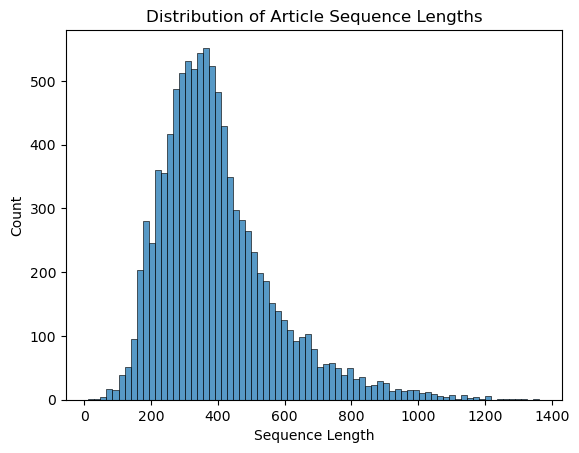

In [7]:
sequence_lengths = list(map(lambda x: len(x), sequences))

sns.histplot(sequence_lengths)

plt.title("Distribution of Article Sequence Lengths")
plt.xlabel("Sequence Length")

plt.show()

In [9]:
MAX_ART_LEN = 1400 # maximum and minimum number of words
X = pad_sequences(sequences, maxlen=MAX_ART_LEN)

print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', y.shape)

Shape of data tensor: (10000, 1400)
Shape of label tensor: (10000,)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Modeling

In [12]:
# 300 because that is the size of Glove
EMBED_SIZE = 300

def create_embeddings_matrix(embeddings):
    # now fill in the matrix, using the ordering from the
    #  keras word tokenizer from before
    found_words = 0
    embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
    for word, i in word_index.items():
        try:
            embedding_vector = np.array(embeddings.loc[[word]])
        except:
            continue
        # words not found in embedding index will be ALL-ZEROS
        embedding_matrix[i] = embedding_vector
        found_words = found_words+1

    print("Embedding Shape:",embedding_matrix.shape, "\n",
        "Total words found:",found_words, "\n",
        "Percentage:",100*found_words/embedding_matrix.shape[0])
    
    return embedding_matrix

embedding_matrix = create_embeddings_matrix(embeddings)

Embedding Shape: (41579, 300) 
 Total words found: 27452 
 Percentage: 66.02371389403305


In [16]:
# first layer of network: find all the embeddings
# save this embedding now
embedding_layer = Embedding(
    len(word_index) + 1,
    EMBED_SIZE,
    embeddings_initializer=Constant(embedding_matrix),# here is the embedding getting saved
    input_length=MAX_ART_LEN,
    trainable=False
)

# CNN 1:

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 1400)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 1400, 300) │ 12,473,700 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 1396, 64)  │     96,064 │ embedding_2[1][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 279, 64)   │          0 │ conv1d_3[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 279, 64)   │          0 │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 275, 64)   │     20,544 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 55, 64)    │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 55, 64)    │          0 │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 51, 64)    │     20,544 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 51, 64)    │          0 │ conv1d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ dropout_6[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract_1          │ (None, 51, 64)    │          0 │ dropout_6[0][0],  │
│ (Subtract)          │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ power_1 (Power)     │ (None, 51, 64)    │          0 │ subtract_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ power_1[0][0]     │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_1            │ (None, 128)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ concat_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 64)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         65 │ dropout_7[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 12,619,173 (48.14 MB)

 Trainable params: 145,473 (568.25 KB)

 Non-trainable params: 12,473,700 (47.58 MB)

None


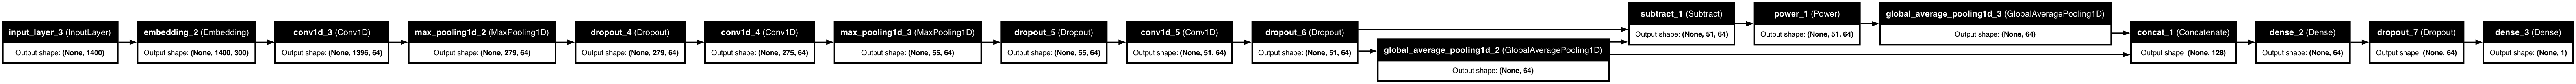

In [22]:
# the input is a list of integers, 500 long
sequence_input = Input(shape=(X_train.shape[1], ))

# this will reduce the input dimension from VOCAB_SIZE to 50 for each word
# the lenght will be the maximum number of words in a document, so 500
embedded_sequences = embedding_layer(sequence_input)

# starting sequence size is 500 (words) by 50 (embedded features)
x = Conv1D(64, 5, activation='relu',
           kernel_initializer='he_uniform')(embedded_sequences)

# after conv, length becomes: 500-4=496 
# so overall size is 496 by 64

# now pool across time
x = MaxPooling1D(5)(x)# after max pool, 496/5 -> 99 by 64
x = Dropout(0.2)(x)

# extract additional features
x = Conv1D(64, 5, activation='relu',
           kernel_initializer='he_uniform')(x)

# new size is 95 after the conovlutions
x = MaxPooling1D(5)(x) # after max pool, size is 95/5 = 19 by 64
x = Dropout(0.2)(x)

# more features through CNN processing!
x = Conv1D(64, 5, activation='relu',
           kernel_initializer='he_uniform')(x)
x = Dropout(0.2)(x)

# after convolution, size becomes 15 elements long
# Take the mean of these elements across features, result is 64 elements
x_mean = GlobalAveragePooling1D()(x) # this is the size to globally flatten 

# Take the variance of these elements across features, result is 64 elements
x_tmp = Subtract()([x,x_mean])
x_std = GlobalAveragePooling1D()(x_tmp**2)

x = Concatenate(name='concat_1')([x_mean,x_std])

x = Dense(64, activation='relu',
          kernel_initializer='he_uniform')(x)

x = Dropout(0.2)(x)

preds = Dense(1, activation='sigmoid',
              kernel_initializer='glorot_uniform')(x)

model1 = Model(sequence_input, preds)

print(model1.summary())

# you will need to install pydot properly on your machine to get this running
plot_model(
    model1, to_file='model1.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [24]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay


lr_schedule = ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.95,
    staircase=True) 
# clipnorm=1.0, 

opt = Adam(epsilon=0.0001, learning_rate=lr_schedule)
model1.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['acc'])

In [25]:
history1 = []
tmp = model1.fit(X_train, y_train, epochs=5, 
                batch_size=64, 
                validation_data=(X_test, y_test))
history1.append( tmp )

Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 45s 339ms/step - acc: 0.7089 - loss: 0.5236 - val_acc: 0.9175 - val_loss: 0.2452
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 42s 338ms/step - acc: 0.9297 - loss: 0.1934 - val_acc: 0.9520 - val_loss: 0.1539
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 42s 336ms/step - acc: 0.9550 - loss: 0.1328 - val_acc: 0.9665 - val_loss: 0.1224
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 42s 334ms/step - acc: 0.9646 - loss: 0.1068 - val_acc: 0.9525 - val_loss: 0.1316
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 43s 342ms/step - acc: 0.9846 - loss: 0.0488 - val_acc: 0.9510 - val_loss: 0.1306


In [26]:
tmp = model1.fit(X_train, y_train, epochs=5, 
                batch_size=64, 
                validation_data=(X_test, y_test))
history1.append( tmp )

Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 50s 400ms/step - acc: 0.9780 - loss: 0.0678 - val_acc: 0.9195 - val_loss: 0.2253
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 45s 357ms/step - acc: 0.9879 - loss: 0.0361 - val_acc: 0.9800 - val_loss: 0.0744
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 46s 369ms/step - acc: 0.9919 - loss: 0.0270 - val_acc: 0.9810 - val_loss: 0.0713
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 43s 340ms/step - acc: 0.9963 - loss: 0.0133 - val_acc: 0.9790 - val_loss: 0.0784
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 43s 339ms/step - acc: 0.9948 - loss: 0.0191 - val_acc: 0.9730 - val_loss: 0.0843


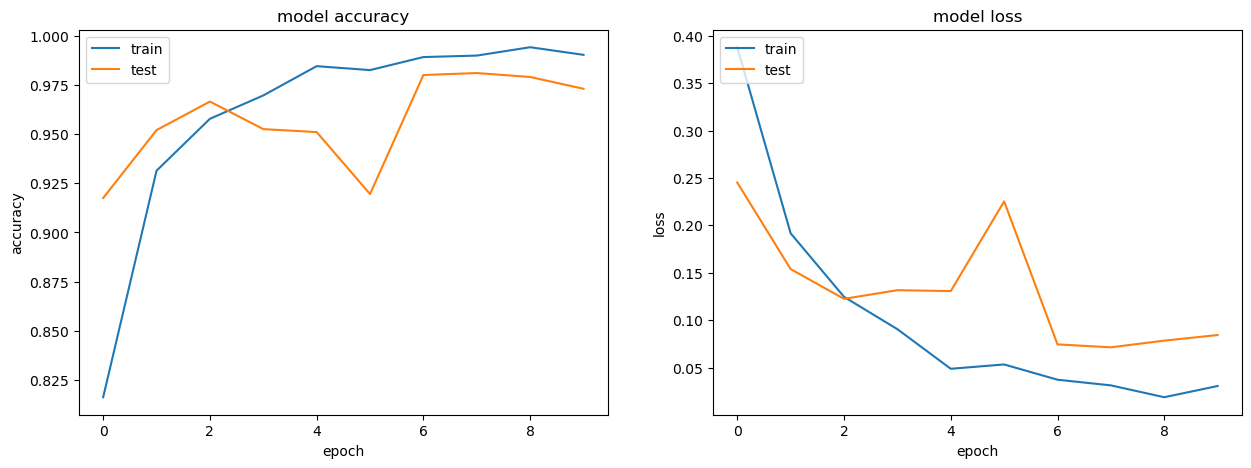

In [27]:
# combine all the history from training together
combined = dict()
for key in ['acc','val_acc','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in history1])
    
# summarize history for accuracy
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['acc'])
plt.plot(combined['val_acc'])
plt.title('model 1 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('model 1 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# CNN 2 (with one less layer):

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 1400)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 1400, 300) │ 12,473,700 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 1396, 64)  │     96,064 │ embedding_2[2][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 279, 64)   │          0 │ conv1d_6[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 279, 64)   │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 275, 64)   │     20,544 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 275, 64)   │          0 │ conv1d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ dropout_9[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract_2          │ (None, 275, 64)   │          0 │ dropout_9[0][0],  │
│ (Subtract)          │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ power_2 (Power)     │ (None, 275, 64)   │          0 │ subtract_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ power_2[0][0]     │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_1            │ (None, 128)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      8,256 │ concat_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 64)        │          0 │ dense_4[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         65 │ dropout_10[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 12,598,629 (48.06 MB)

 Trainable params: 124,929 (488.00 KB)

 Non-trainable params: 12,473,700 (47.58 MB)

None


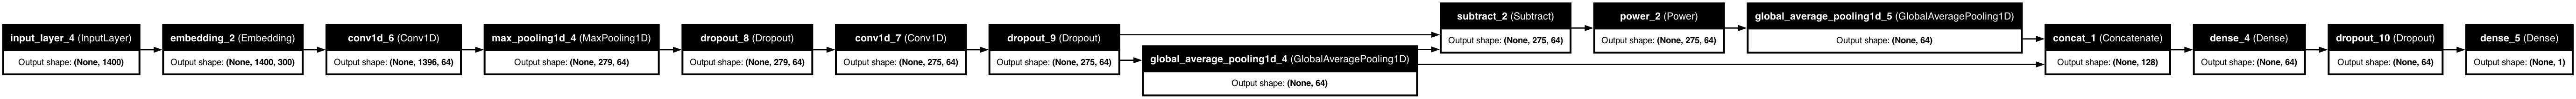

In [28]:
# the input is a list of integers, 500 long
sequence_input = Input(shape=(X_train.shape[1], ))

# this will reduce the input dimension from VOCAB_SIZE to 50 for each word
# the lenght will be the maximum number of words in a document, so 500
embedded_sequences = embedding_layer(sequence_input)

# starting sequence size is 500 (words) by 50 (embedded features)
x = Conv1D(64, 5, activation='relu',
           kernel_initializer='he_uniform')(embedded_sequences)

# after conv, length becomes: 500-4=496 
# so overall size is 496 by 64

# now pool across time
x = MaxPooling1D(5)(x)# after max pool, 496/5 -> 99 by 64
x = Dropout(0.2)(x)

# more features through CNN processing!
x = Conv1D(64, 5, activation='relu',
           kernel_initializer='he_uniform')(x)
x = Dropout(0.2)(x)

# after convolution, size becomes 15 elements long
# Take the mean of these elements across features, result is 64 elements
x_mean = GlobalAveragePooling1D()(x) # this is the size to globally flatten 

# Take the variance of these elements across features, result is 64 elements
x_tmp = Subtract()([x,x_mean])
x_std = GlobalAveragePooling1D()(x_tmp**2)

x = Concatenate(name='concat_1')([x_mean,x_std])

x = Dense(64, activation='relu',
          kernel_initializer='he_uniform')(x)

x = Dropout(0.2)(x)

preds = Dense(1, activation='sigmoid',
              kernel_initializer='glorot_uniform')(x)

model2 = Model(sequence_input, preds)

print(model2.summary())

# you will need to install pydot properly on your machine to get this running
plot_model(
    model2, to_file='model2.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [29]:
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.95,
    staircase=True) 
# clipnorm=1.0, 

opt = Adam(epsilon=0.0001, learning_rate=lr_schedule)
model2.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['acc'])

In [30]:
history2 = []
tmp = model2.fit(X_train, y_train, epochs=5, 
                batch_size=64, 
                validation_data=(X_test, y_test))
history2.append( tmp )

Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 45s 341ms/step - acc: 0.6852 - loss: 0.5442 - val_acc: 0.9030 - val_loss: 0.2402
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 42s 335ms/step - acc: 0.9196 - loss: 0.2119 - val_acc: 0.9270 - val_loss: 0.1851
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 46s 369ms/step - acc: 0.9558 - loss: 0.1279 - val_acc: 0.9185 - val_loss: 0.2010
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 330ms/step - acc: 0.9694 - loss: 0.0927 - val_acc: 0.9355 - val_loss: 0.1620
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 42s 333ms/step - acc: 0.9756 - loss: 0.0766 - val_acc: 0.9750 - val_loss: 0.0954


In [31]:
tmp = model2.fit(X_train, y_train, epochs=5, 
                batch_size=64, 
                validation_data=(X_test, y_test))
history2.append( tmp )

Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 42s 332ms/step - acc: 0.9839 - loss: 0.0536 - val_acc: 0.9695 - val_loss: 0.0900
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 331ms/step - acc: 0.9880 - loss: 0.0368 - val_acc: 0.9720 - val_loss: 0.0842
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 328ms/step - acc: 0.9944 - loss: 0.0232 - val_acc: 0.9485 - val_loss: 0.1275
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 45s 362ms/step - acc: 0.9939 - loss: 0.0218 - val_acc: 0.9725 - val_loss: 0.0864
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 329ms/step - acc: 0.9956 - loss: 0.0165 - val_acc: 0.9680 - val_loss: 0.0969


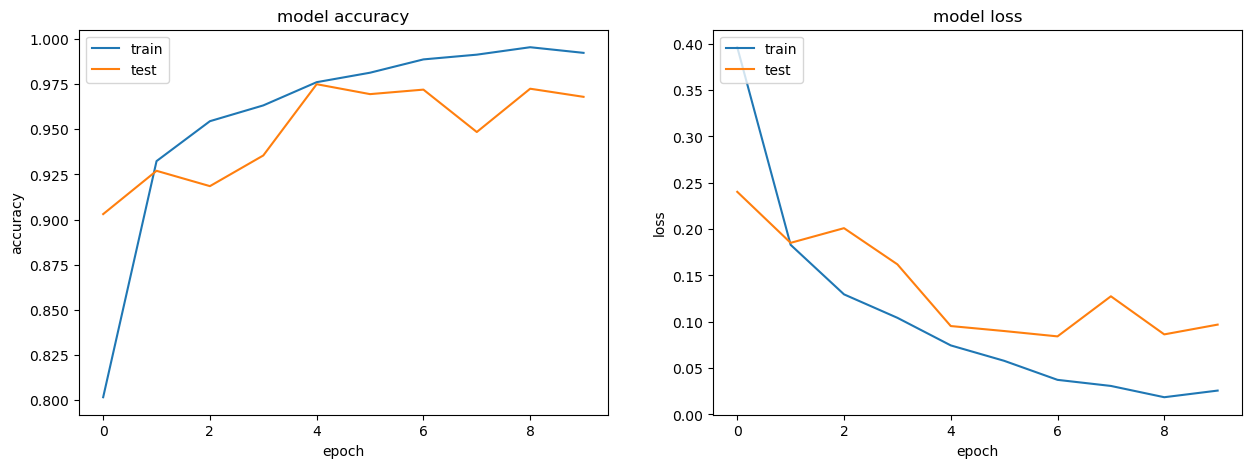

In [32]:
# combine all the history from training together
combined = dict()
for key in ['acc','val_acc','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in history2])
    
# summarize history for accuracy
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['acc'])
plt.plot(combined['val_acc'])
plt.title('model 2 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('model 2 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Use F1 ad the threshold/confidence level becasue we dont want to prioritize one or the other with falsely assuming a kid using AI to complete their homework or not catching a student that has used AI to complete their homework. False positives for both sides are equally important so the F1 score is perfect for this. 